<a href="https://colab.research.google.com/github/Prabhitha/FakeNewsDetection/blob/main/FakeNewsDetection_W2V_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Word2Vec- Vectorized data on different Machine Learning models
###1. Logistic Regression
###2. Linear SVM
###3. Gradient Boosted Decision Tree(GBDT)
###4. Random Forest

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.2.5/en_core_web_lg-2.2.5.tar.gz
!pip install en_core_web_lg

In [ ]:
#Importing Libraries

import warnings
warnings.filterwarnings('ignore')

import os
import re
import spacy
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
spacy.cli.download('en_core_web_lg')

%matplotlib inline
sns.set(style="whitegrid")
colors = sns.color_palette()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the Pre-processed data

if os.path.isfile('/content/drive/My Drive/Fake News Detection/cleaned_featurized_train.csv'):
  train_data = pd.read_csv('/content/drive/My Drive/Fake News Detection/cleaned_featurized_train.csv')
  train_labels = np.load('/content/drive/My Drive/Fake News Detection/train_labels.npy')
 
  test_data = pd.read_csv('/content/drive/My Drive/Fake News Detection/cleaned_featurized_test.csv')
  test_labels = np.load('/content/drive/My Drive/Fake News Detection/test_labels.npy')

In [ ]:
print(train_data.shape)
train_data.head()

(31428, 2)


,text,label
0,first hand account happen baltimor shock unrea...,0
1,meanwhil american afford take singl vacat judi...,0
2,despit tough talk intern affair slam democrat ...,0
3,hell frozen cnn actual report truth cnn legal ...,0
4,madrid reuter head catalan region govern sunda...,1


In [ ]:
# Encoding questions as unicode
train_data['text'] = train_data['text'].apply(lambda x: str(x))
test_data['text'] = test_data['text'].apply(lambda x: str(x))

## TF - IDF embedding
Let's try simple TF-IDF vectors with 5000 features

In [ ]:
# Initialize vectorizer
vectorizer = TfidfVectorizer(max_features= 5000, ngram_range=(1,3), lowercase=False)

# Vectorizing news
print('Vectorizing News')
q_vecs_tfidf_train = vectorizer.fit_transform(train_data['text'].values)
q_vecs_tfidf_test = vectorizer.transform(test_data['text'].values)

# Mapping terms to their IDF values
print('Mapping terms to their IDF values')
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

print('Converting to DataFrames')
q_tfidf_train = pd.DataFrame.sparse.from_spmatrix(q_vecs_tfidf_train)
q_tfidf_test = pd.DataFrame.sparse.from_spmatrix(q_vecs_tfidf_test)

Vectorizing News
Mapping terms to their IDF values
Converting to DataFrames


In [ ]:
# Printing some random features
vectorizer.get_feature_names()[500:510]

['begin',
 'begun',
 'behalf',
 'behav',
 'behavior',
 'behind',
 'beij',
 'beij reuter',
 'beirut',
 'beirut reuter']

In [ ]:
q_tfidf_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.024395,0.0,0.0,0.0,0.000000,0.023321,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.034921,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022693,0.0,0.0,0.025288,0.022099,0.0,0.0,0.0,0.000000,0.0,0.024941,0.026912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.045519,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.051129,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### IDF weighted average Word2Vec

In [ ]:
#nlp = en_core_web_lg.load()
nlp = spacy.load('en_core_web_lg')
type(nlp)

spacy.lang.en.English

In [ ]:
# Initializing pre-trained vectors
print('Loading pre-trained word vectors model')
nlp = spacy.load('en_core_web_lg')

# Initialize list to store news vectors
q_train_vecs = []
q_test_vecs = []

# Iterate over all news in TRAIN text column
print('Processing train news')
for q in tqdm(list(train_data['text'])):
  # Get vectors for all words in news
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in news
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in question (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q_train_vecs.append(mean_vec)


# Iterate over all news in TEST text column
print('Processing test news')
for q in tqdm(list(test_data['text'])):
  # Get vectors for all words in news
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in news
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in news (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q_test_vecs.append(mean_vec)


# Creating DataFrames for these, (we can merge them with our main DataFrame later)
print('Converting to DataFrames')
q_w2v_train = pd.DataFrame(q_train_vecs, index=train_data.index)
q_w2v_test = pd.DataFrame(q_test_vecs, index=test_data.index)


Loading pre-trained word vectors model
Processing train news


  0%|          | 0/31428 [00:00<?, ?it/s]

Processing test news


  0%|          | 0/13470 [00:00<?, ?it/s]

Converting to DataFrames


In [ ]:
# Save to disk
print('Saving DataFrames as .csv to disk')
print('Saving train news')
q_w2v_train.to_csv('/content/drive/My Drive/Fake News Detection/q_w2v_train.csv')

print('Saving test news')
q_w2v_test.to_csv('/content/drive/My Drive/Fake News Detection/q_w2v_test.csv')

Saving DataFrames as .csv to disk
Saving train news
Saving test news


### Load from disk

In [ ]:
# Reading from disk
print('Reading .csv files from disk')
q_w2v_train = pd.read_csv('/content/drive/My Drive/Fake News Detection/q_w2v_train.csv')
q_w2v_train = q_w2v_train.drop(columns=['Unnamed: 0'])

q_w2v_test = pd.read_csv('/content/drive/My Drive/Fake News Detection/q_w2v_test.csv')
q_w2v_test = q_w2v_test.drop(columns=['Unnamed: 0'])

Reading .csv files from disk


In [ ]:
q_w2v_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.227770,0.219450,-0.057842,-0.127525,0.448653,-0.153173,-0.032461,-0.137759,0.016052,4.141879,-0.320127,-0.068513,0.045141,-0.116752,-0.349016,0.052524,-0.087752,1.761387,-0.050583,-0.184478,0.032083,-0.122312,0.215759,-0.193248,0.185606,-0.113473,-0.367187,-0.124789,0.065314,-0.037738,-0.043471,0.021055,-0.228916,0.084313,0.128178,-0.064489,0.020555,0.063179,-0.186238,-0.071368,...,0.121496,0.322124,-0.060438,0.010589,0.136757,-0.043430,-0.036836,0.056280,-0.334711,0.216035,-0.199000,0.066126,-0.006676,-0.020783,0.017549,0.268283,0.083472,0.064955,0.053255,0.208435,0.014467,-0.054238,-0.363966,0.137070,-0.287191,0.085860,0.306533,0.010393,0.106047,-0.032641,-0.167281,-0.044051,0.074005,-0.314221,0.138705,-0.106046,0.139878,0.121440,0.020135,0.161405
1,0.052443,0.315814,0.397388,-0.222249,0.284487,-0.181313,0.013635,-0.285509,0.056446,4.094457,-0.861862,-0.037712,0.133663,0.165575,-0.292101,-0.037436,-0.378762,2.096479,0.028541,0.112852,0.145918,0.185655,0.051499,-0.174381,0.084210,-0.013646,-0.743673,-0.095930,0.077344,0.418160,0.069622,-0.217421,0.122879,0.213614,-0.110597,0.121278,0.072980,-0.182517,-0.032711,0.031123,...,0.201958,0.169594,-0.142045,0.016013,0.097797,-0.635741,-0.041514,0.062398,-0.273575,0.157741,-0.349381,-0.056456,0.179140,0.373208,0.199523,0.448173,-0.001588,-0.084208,0.042009,-0.015899,-0.069550,-0.242406,-0.069385,0.412988,-0.019130,-0.008492,0.118121,-0.111095,0.009849,0.410756,-0.015602,0.210394,-0.041183,-0.274959,0.306039,-0.202182,0.036112,-0.079981,-0.118657,0.113624
2,-0.092034,0.162112,0.062404,-0.005395,0.009646,0.065739,0.078406,0.131279,-0.098723,2.935951,-0.227152,-0.211408,0.105767,0.131522,-0.035186,0.022492,-0.256956,0.652230,-0.024036,0.186228,0.084584,-0.061602,0.186924,-0.152843,0.236605,-0.137644,-0.494614,-0.092735,0.161135,0.331735,0.133350,-0.029475,-0.057941,-0.064043,0.083049,-0.014492,0.047091,-0.249544,0.009249,0.126432,...,-0.059357,0.262985,-0.276276,0.023985,0.060596,-0.280840,0.045305,0.029939,-0.040366,0.242684,-0.260613,0.058248,-0.046315,0.258701,-0.088256,0.271349,0.077792,-0.073286,0.440543,0.046915,0.068745,-0.348936,-0.268650,0.059066,-0.246273,0.171047,0.137718,0.061775,0.139573,0.113196,-0.056935,0.193578,-0.262116,-0.471510,0.358220,-0.017772,0.076929,-0.008346,-0.212076,0.258582
3,-0.546350,0.380399,-0.075013,-0.058701,0.448061,0.001343,0.122754,-0.368398,0.142627,4.411420,-0.473788,-0.666759,0.405679,-0.121116,-0.520197,0.005041,0.012298,1.478683,0.007231,0.035397,0.540850,0.133654,0.404297,-0.636668,-0.059212,-0.306044,-0.359735,-0.052449,-0.057921,0.058981,-0.181133,0.152271,0.289530,0.272477,0.033643,-0.017009,-0.121293,0.200000,-0.513380,-0.340789,...,0.150959,0.302711,0.189718,0.231543,0.242644,-0.451535,0.093734,0.200133,0.228046,0.367323,-0.157413,0.234621,0.052210,0.047236,0.451880,0.535172,-0.070353,-0.107767,0.052915,-0.469855,-0.218392,-0.292354,-0.146505,0.535142,-0.165871,0.091642,0.186398,0.214314,0.118642,0.146370,0.163290,-0.191343,-0.087055,-0.067127,0.520921,-0.267934,0.209608,-0.049685,-0.373166,0.542318
4,-0.011167,0.102854,0.163609,-0.040855,0.562603,-0.518129,0.008029,-0.144784,-0.255241,4.080216,-0.862834,-0.004639,-0.090528,0.065527,-0.356910,-0.044290,-0.390548,1.169512,0.723194,-0.148960,0.792522,-0.063427,0.488919,0.060988,-0.046984,-0.105028,-0.806194,0.344511,-0.394147,0.779697,-0.021682,-0.449708,0.326728,-0.067743,0.190448,0.147925,0.159678,-0.197611,-0.255878,-0.179108,...,0.385959,-0.072500,-0.162677,0.598524,-0.134170,-0.592117,-0.032021,-0.506837,-0.206643,0.153409,-0.274870,-0.210229,-0.263477,0.600675,0.402261,0.378229,0.200400,-0.188564,0.537043,0.165233,0.140113,-0.431194,-0.497970,0.645716,0.000051,0.200726,0.582366,0.058967,0.275495,-0.028391,0.38

In [ ]:
q_w2v_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31428 entries, 0 to 31427
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 71.9 MB


In [ ]:
print("Number of data points in train data :",q_w2v_train.shape)
print("Train labels :",train_labels.shape)

print("Number of data points in test data :",q_w2v_test.shape)
print("Test labels :",test_labels.shape)

Number of data points in train data : (31428, 300)
Train labels : (31428,)
Number of data points in test data : (13470, 300)
Test labels : (13470,)


### 4.4 Building a random model (Finding worst-case log-loss)

Defining function to print confusion matrices

In [ ]:
def plot_confusion_matrices(true, pred):
  # Normal confusion matrix
  conf = confusion_matrix(true, pred)
  
  # Precision matrix
  # Precision: Out of all the points predicted of class 'A', how many are actually class 'A'
  # A column in the confusion matrix represents the data points predicted as the same class
  # So we divide all data points by the sum of points in their respective columns
  precision = (conf.T / conf.sum(axis=1)).T

  # Recall matrix
  # Recall: Out of all the points which are of class 'A', how many were predicted to be of class 'A'
  # A row in the confusion matrix represents the data points of the same class
  # So we divide all data points by the sum of points in their respective rows
  recall = (conf / conf.sum(axis=0))

  # Plotting the matrices
  plt.figure(figsize=(24,6))

  # Set axes labels
  labels = ['0', '1']

  # Set colourmap
  cmap = sns.light_palette('purple')

  # Plot normal confusion matrix
  plt.subplot(1, 3, 1)
  sns.heatmap(conf, cmap=cmap, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Plot precision confusion matrix
  plt.subplot(1, 3, 2)
  sns.heatmap(precision, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Precision Matrix')

  # Plot recall confusion matrix
  plt.subplot(1, 3, 3)
  sns.heatmap(recall, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Recall Matrix')

  plt.show()

## Model 1

### Creating data matrices

In [ ]:
# First, let's standardize our features.

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
model_train = scaler.fit_transform(q_w2v_train)

# Test data
model_test = scaler.transform(q_w2v_test)

### Visualization using t-SNE:

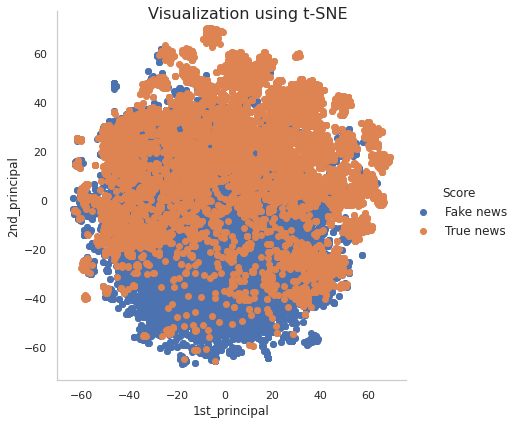

In [ ]:
# TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(model_train)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, train_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Fake news', 'True news']

# Ploting the result of tsne
g= sns.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('Visualization using t-SNE', fontsize=16)
g.ax.grid(False)
plt.show()

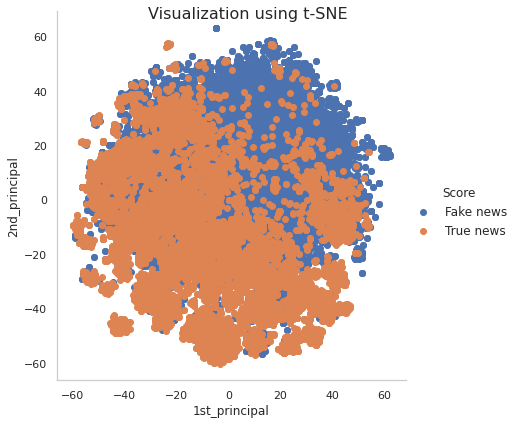

In [ ]:
# TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)
tsne_data = model.fit_transform(model_train)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, train_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Fake news', 'True news']

# Ploting the result of tsne
g= sns.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('Visualization using t-SNE', fontsize=16)
g.ax.grid(False)
plt.show()

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88959



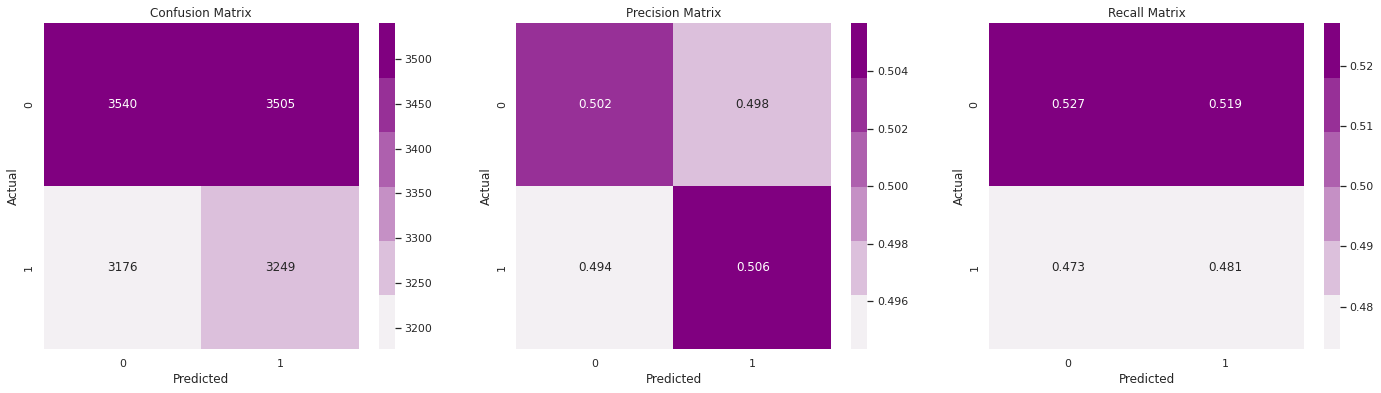

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression with hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.16142475403635304
Regularization: L1	alpha = 0.0001	loss: 0.17379120748575275
Regularization: L1	alpha = 0.001	loss: 0.18363684372941105
Regularization: L1	alpha = 0.01	loss: 0.24175727953186998
Regularization: L1	alpha = 0.1	loss: 0.41943473906207573
Regularization: L1	alpha = 1	loss: 0.6920875114726791
Regularization: L1	alpha = 10	loss: 0.6920875114726875

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.16642821341161232
Regularization: L2	alpha = 0.0001	loss: 0.15773577570089448
Regularization: L2	alpha = 0.001	loss: 0.16150242003728507
Regularization: L2	alpha = 0.01	loss: 0.18256522843518258
Regularization: L2	alpha = 0.1	loss: 0.22961634410581555
Regularization: L2	alpha = 1	loss: 0.2924098027867093
Regularization: L2	alpha = 10	loss: 0.33727974094102126

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.16300547294310822
Regularization: ElasticNet	alpha = 0.0001	loss: 0.15656788750300

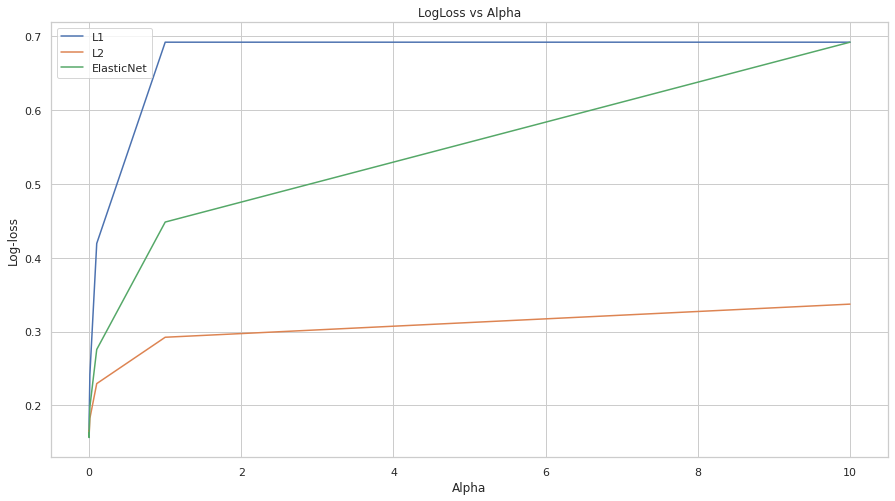

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Log loss for best alpha on train data: 0.14162859658135
Log loss for best alpha on test data: 0.15656788750300454




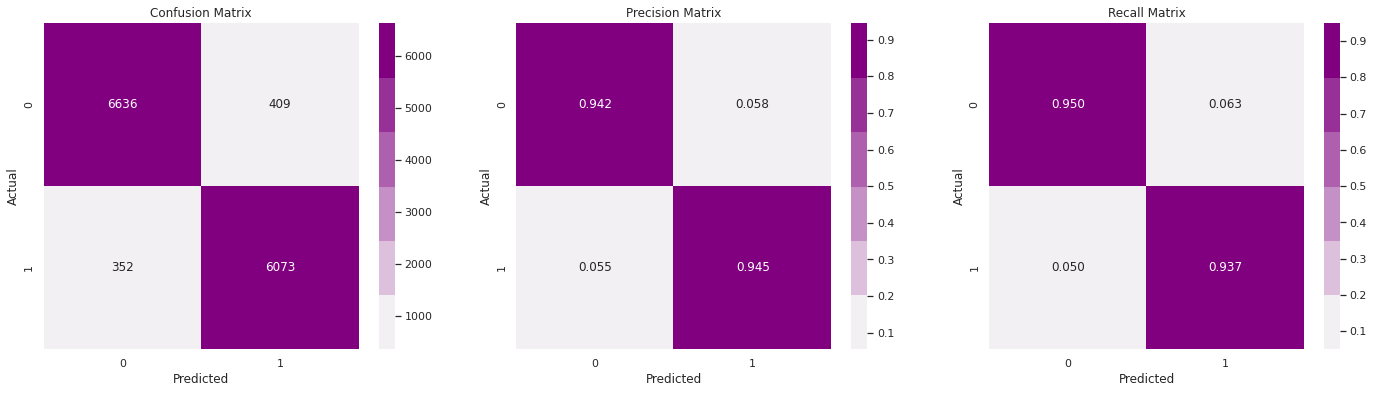

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf_LR = SGDClassifier(loss='log', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf_LR.fit(model_train, train_labels)

# Initialize calibration model
cal_clf_LR = CalibratedClassifierCV(sgd_clf_LR)

# Fit calibration model
cal_clf_LR.fit(model_train, train_labels)

# Predict
predict_train = cal_clf_LR.predict_proba(model_train)
predict_test = cal_clf_LR.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(cal_clf_LR, open('/content/drive/My Drive/Fake News Detection/W2V/LR_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9458444698994527
Test Accuracy: 0.9435040831477357


### Linear SVM with Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.1701976598777037
Regularization: L1	alpha = 0.0001	loss: 0.1720077241409086
Regularization: L1	alpha = 0.001	loss: 0.1846989289221017
Regularization: L1	alpha = 0.01	loss: 0.229376451620662
Regularization: L1	alpha = 0.1	loss: 0.36111057894973647
Regularization: L1	alpha = 1	loss: 0.6920875114727124
Regularization: L1	alpha = 10	loss: 0.6920875114727549

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.17041242972242213
Regularization: L2	alpha = 0.0001	loss: 0.15892664844212792
Regularization: L2	alpha = 0.001	loss: 0.15848690958748501
Regularization: L2	alpha = 0.01	loss: 0.16928979349181528
Regularization: L2	alpha = 0.1	loss: 0.19929046065655595
Regularization: L2	alpha = 1	loss: 0.2599307185805041
Regularization: L2	alpha = 10	loss: 0.32146762283444874

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.1685540609086308
Regularization: ElasticNet	alpha = 0.0001	loss: 0.16020910680600373
Re

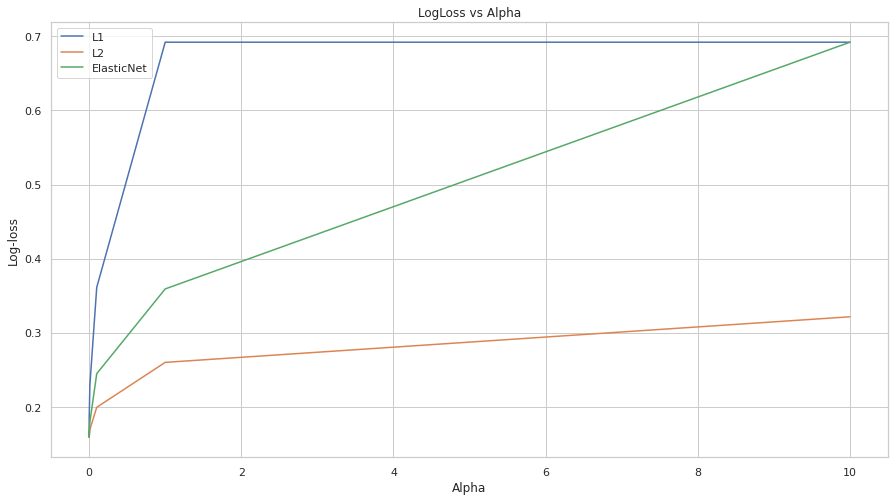

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Log loss for best alpha on train data: 0.14241446641399394
Log loss for best alpha on test data: 0.15848690958748501




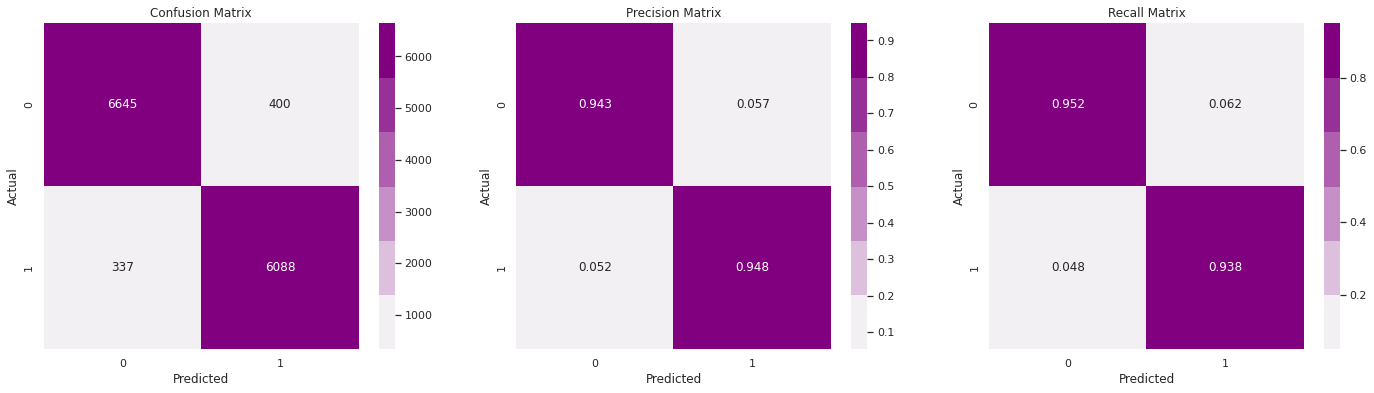

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf_SVM = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf_SVM.fit(model_train, train_labels)

# Initialize calibration model
cal_clf_SVM = CalibratedClassifierCV(sgd_clf_SVM)

# Fit calibration model
cal_clf_SVM.fit(model_train, train_labels)

# Predict
predict_train = cal_clf_SVM.predict_proba(model_train)
predict_test = cal_clf_SVM.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(cal_clf_SVM, open('/content/drive/My Drive/Fake News Detection/W2V/SVM_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9467035764286623
Test Accuracy: 0.9452858203414997


### GDBT: XgBoost with Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6, 8]
n_estimators = [10, 100, 500, 1000]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_train, train_labels)

    # Predict on test data
    pred_prob = gbdt_clf.predict_proba(model_test)

    # Get log loss on training data
    pred_prob_training = gbdt_clf.predict_proba(model_train)
    loss_training = log_loss(train_labels, pred_prob_training)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

    # Print training and test loss for this iteration
    print('Train loss: {0} \tTest loss: {1}\n'.format(loss_training, loss))

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Train loss: 0.5031828082717678 	Test loss: 0.5026282619505169

Running at depth: 2, n_estimators: 100
Train loss: 0.2728390770153136 	Test loss: 0.2841035279168788

Running at depth: 2, n_estimators: 500
Train loss: 0.15311452300195835 	Test loss: 0.1863431353280379

Running at depth: 2, n_estimators: 1000
Train loss: 0.10551792442790742 	Test loss: 0.15344237222943255

Running at depth: 4, n_estimators: 10
Train loss: 0.4461222132422534 	Test loss: 0.44985827824851715

Running at depth: 4, n_estimators: 100
Train loss: 0.17657956371764805 	Test loss: 0.21550845803914015

Running at depth: 4, n_estimators: 500
Train loss: 0.039427535434574605 	Test loss: 0.12146355771457777

Running at depth: 4, n_estimators: 1000
Train loss: 0.00906622009608591 	Test loss: 0.1055950228069444

Running at depth: 6, n_estimators: 10
Train loss: 0.40071805068231864 	Test loss: 0.4165790763192028

Running at depth: 6, n_estimators: 100
Train loss: 0.08564334561446159 	

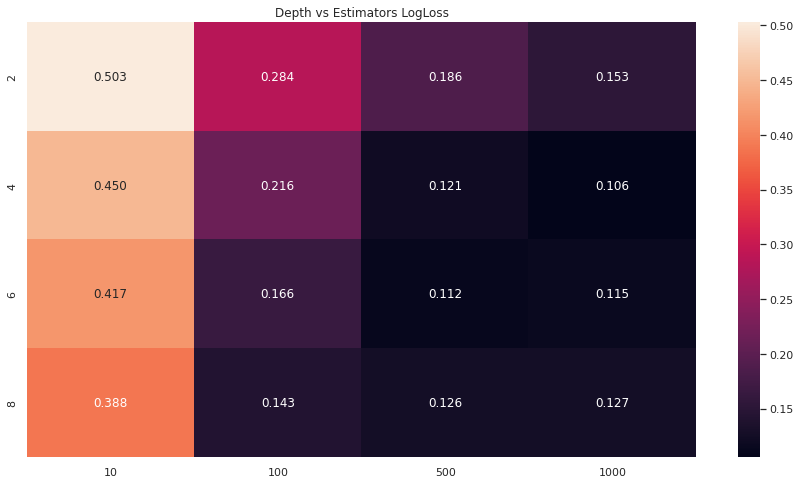

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.15311452300195835
Log loss for best alpha on test data: 0.1863431353280379




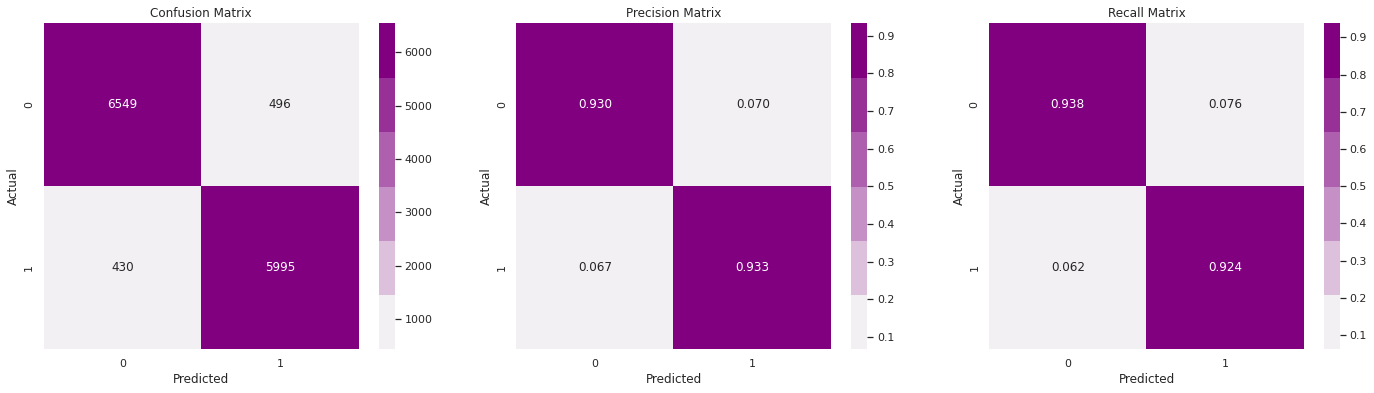

In [ ]:
# Setting best hyperparameters
# Not providing the best hyper parameters because it's overfitting

n_estimators= 500
max_depth= 2 

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_train, train_labels)

# Predict
predict_train = gbdt_clf.predict_proba(model_train)
predict_test = gbdt_clf.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(gbdt_clf, open('/content/drive/My Drive/Fake News Detection/W2V/GBDT_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.949567264859361
Test Accuracy: 0.9312546399406088


### Random Forest with Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [4, 6, 8, 10]
n_estimators = [100, 500, 1000, 1500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = RandomForestClassifier(max_depth=depth, n_estimators=n, n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_train, train_labels)

    # Predict on test data
    pred_prob = gbdt_clf.predict_proba(model_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 4, n_estimators: 1000
Running at depth: 4, n_estimators: 1500
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500
Running at depth: 6, n_estimators: 1000
Running at depth: 6, n_estimators: 1500
Running at depth: 8, n_estimators: 100
Running at depth: 8, n_estimators: 500
Running at depth: 8, n_estimators: 1000
Running at depth: 8, n_estimators: 1500
Running at depth: 10, n_estimators: 100
Running at depth: 10, n_estimators: 500
Running at depth: 10, n_estimators: 1000
Running at depth: 10, n_estimators: 1500


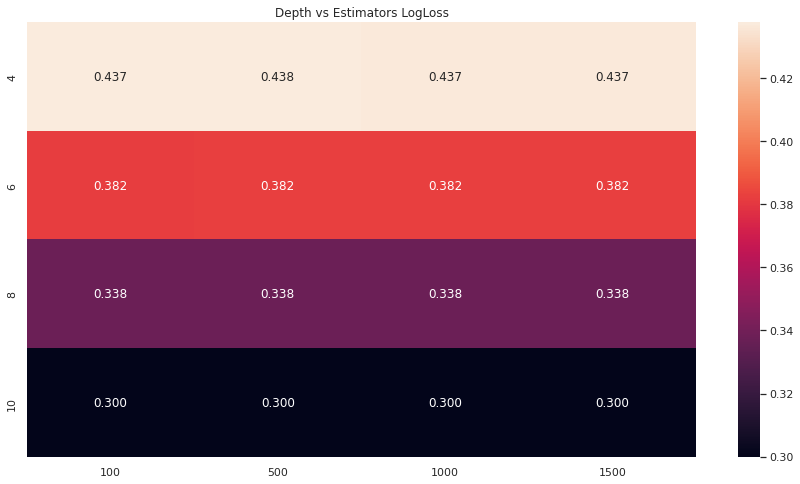

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

Log loss for best alpha on train data: 0.29895697494142826
Log loss for best alpha on test data: 0.3380179816908476




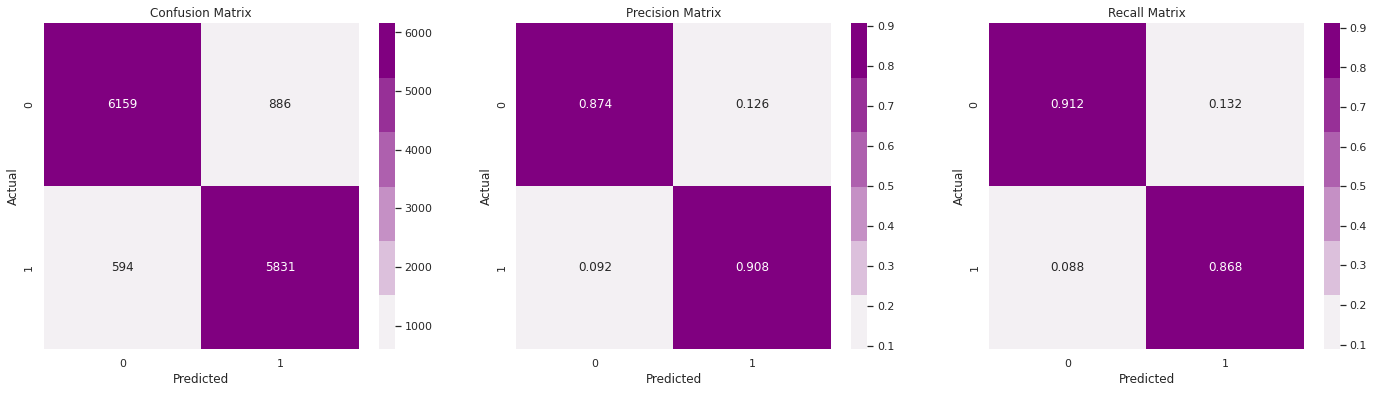

In [ ]:
# Setting best hyperparameters
n_estimators=500
max_depth= 8 

# Initialize model
rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, criterion='gini', n_jobs=-1, random_state=42)

# Fitting on train data
rf_clf.fit(model_train, train_labels)

# Predict
predict_train = rf_clf.predict_proba(model_train)
predict_test = rf_clf.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(rf_clf, open('/content/drive/My Drive/Fake News Detection/W2V/RF_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9192439862542955
Test Accuracy: 0.8901262063845583


### Testing News data on Random Forest

In [ ]:
# Initializing pre-trained vectors

nlp = spacy.load('en_core_web_lg')

# Initialize list to store news vector
query_vector = []

query_news = "Reuters - Alabama officials on Thursday certified Democrat Doug Jones the winner of the U.S. Senate race, after a \
              state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual \
              misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes or 1.6 percentage points, election \
              officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama. \
              The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general.\
              A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General \
              Steve Marshall certified the election results.Seating Jones will narrow the Republican majority in Senate to 51 of 100 seats."

query_news_fake = "On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the \
                    fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump \
                   is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at \
                   Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year.\
                   That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this \
                   administration is bizarre AF. The coding contained a reference to Obama and golf Unlike Obama, we are working to \
                   fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, \
                   who has spent several days in a row at the golf course, is coded to serve up the following message in the event of an \
                   internal server error. The golf error message has been removed from the Trump and GOP websites."

doc = nlp(query_news_fake)
mean_vec = np.zeros((len(doc[0].vector)))
for word in doc:
  vector = word.vector
  if str(word) in idf:
    idf_weight = idf[str(word)]
  else:
    idf_weight = 0
    
  # Add IDF weighted vector to mean vector
  mean_vec += vector * idf_weight
  
# Divide mean vector by number of words in question (averaged vector)
mean_vec /= len(doc)
query_vector.append(mean_vec)


# Prediction
predict_prob = rf_clf.predict_proba(query_vector)
print("Predicted probability", predict_prob)

predicted = rf_clf.predict(query_vector)

if (predicted == 0):
  print("The news is Fake")
else:
  print("The news is True")


Predicted probability [[0.61094817 0.38905183]]
The news is Fake


### Pretty Table

In [ ]:
# Initializing table
table = PrettyTable()

# Setting header names
print('Word2Vec Vectorizer')
table.field_names = ['Model', 'Hyper Parameter', 'Train log-loss', 'Test log-loss', 'Train Accuracy', 'Test Accuracy']

# Setting rows
table.add_row(['Logistic Regression', 'ElasticNet, alpha = 0.0001', '0.142', '0.157', '94.58%', '94.35%'])
table.add_row(['Linear SVM', 'L2 loss, alpha = 0.001', '0.142', '0.158', '94.67%', '94.52%'])
table.add_row(['GBDT', 'Estimators= 500, Max_depth= 2', '0.153', '0.186', '94.95%', '93.12%'])
table.add_row(['Random Forest', 'Estimators= 500, Max_depth= 8', '0.298', '0.338', '91.92%', '89.01%'])
table.add_row(['Random Model', '-', '-', '0.889', '-', '-'])

print(table)

Word2Vec Vectorizer
+---------------------+-------------------------------+----------------+---------------+----------------+---------------+
|        Model        |        Hyper Parameter        | Train log-loss | Test log-loss | Train Accuracy | Test Accuracy |
+---------------------+-------------------------------+----------------+---------------+----------------+---------------+
| Logistic Regression |   ElasticNet, alpha = 0.0001  |     0.142      |     0.157     |     94.58%     |     94.35%    |
|      Linear SVM     |     L2 loss, alpha = 0.001    |     0.142      |     0.158     |     94.67%     |     94.52%    |
|         GBDT        | Estimators= 500, Max_depth= 2 |     0.153      |     0.186     |     94.95%     |     93.12%    |
|    Random Forest    | Estimators= 500, Max_depth= 8 |     0.298      |     0.338     |     91.92%     |     89.01%    |
|     Random Model    |               -               |       -        |     0.889     |       -        |       -       |
+---